# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [45]:
# load weekly sales dataset
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error


filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

[Text(0.5, 1.0, 'Sales Time Series Data')]

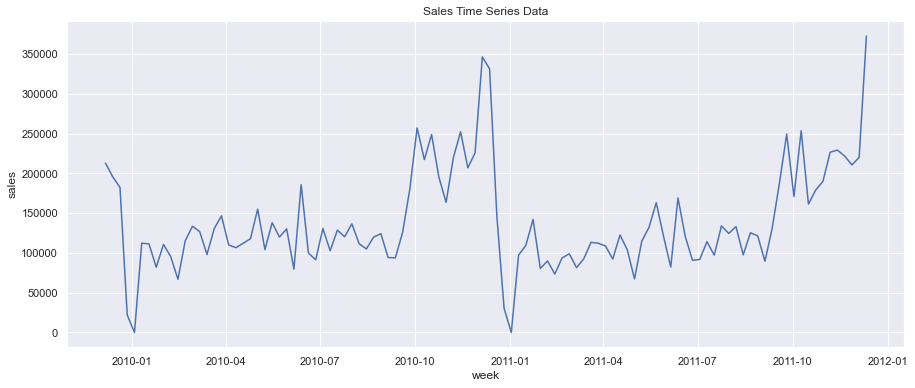

In [46]:
import seaborn as sns


sns.set(rc={'figure.figsize':(15, 6)})
sns.lineplot(x=df.index, y='sales', data=df).set(title='Sales Time Series Data')

## Missing data

Check if there are missing values in the time series.

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2009-12-06 to 2011-12-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   106 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


In [48]:
df.isna().sum()

sales    0
dtype: int64

## Missing timestamps

Check if there are missing timestamps in the index.

In [49]:
df.index = pd.to_datetime(df.index)

In [50]:
df_ = df.asfreq('1W')
df_imputed = df_.fillna(method='ffill')

df_imputed.shape, df.shape

((106, 1), (106, 1))

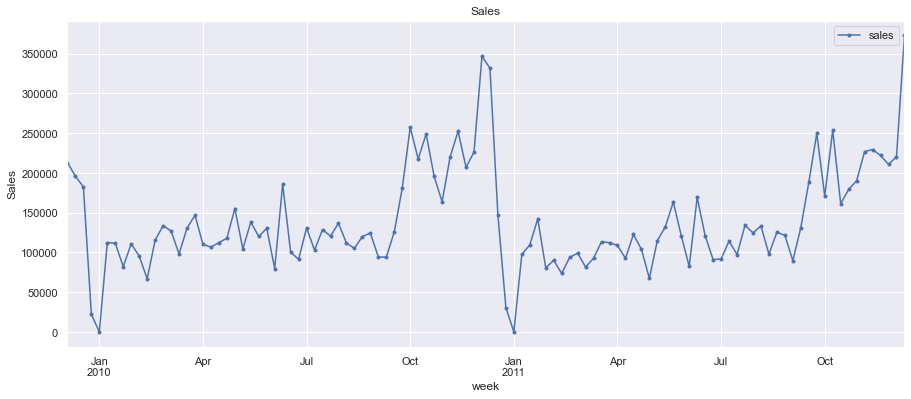

In [51]:
import matplotlib.pyplot as plt


ax = df_.plot(linestyle="-", marker=".", figsize=(15, 6))
df_imputed[df_.isnull()].plot(ax=ax, legend=None, marker=".", color="r")


plt.title("Sales")
plt.ylabel("Sales")

plt.show()

## Seasonality

Does the time series show any obvious seasonal pattern?

In [52]:
month = df.index.month
month = pd.Series(month, index=df.index)
month.head()

week
2009-12-06    12
2009-12-13    12
2009-12-20    12
2009-12-27    12
2010-01-03     1
Name: week, dtype: int64

<AxesSubplot: xlabel='week'>

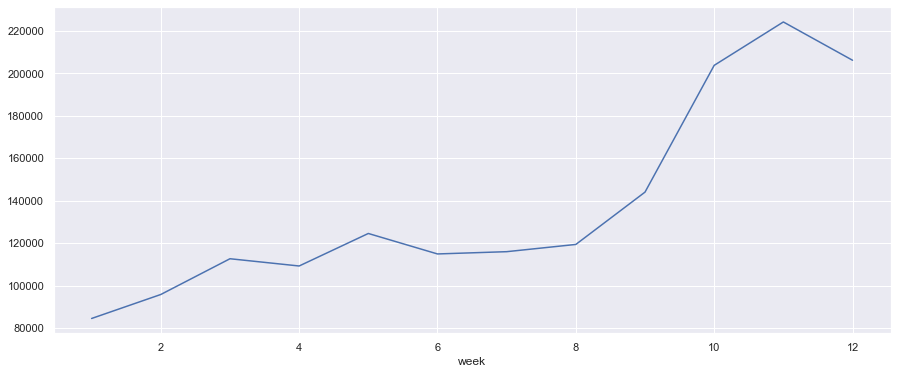

In [53]:
df.groupby(month).sales.mean().plot(figsize=(15, 6))

<AxesSubplot: xlabel='week'>

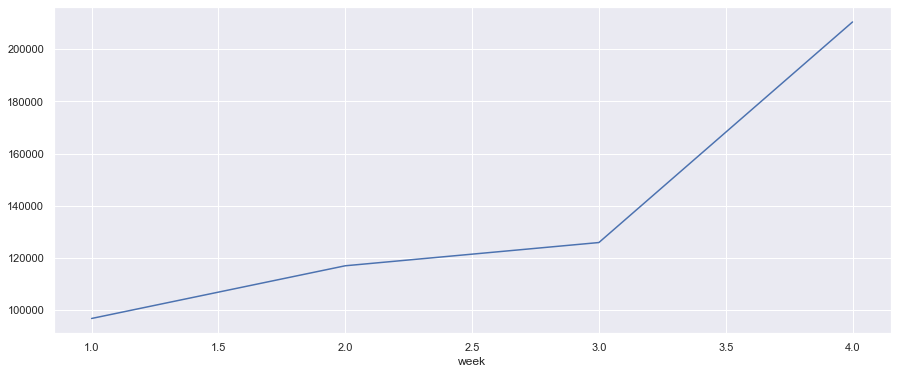

In [54]:
quarter = df.index.quarter

df.groupby(quarter)["sales"].mean().plot(figsize=(15, 6))

<AxesSubplot: xlabel='week'>

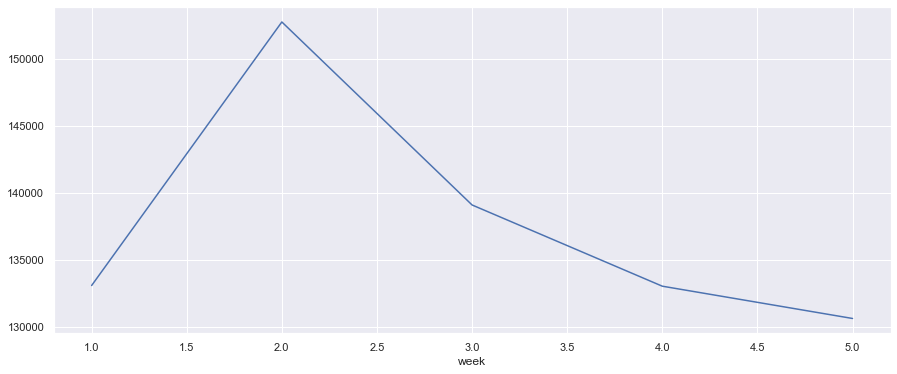

In [55]:
wom = (df.index.day - 1) // 7 + 1

df.groupby(wom)["sales"].mean().plot(figsize=(15, 6))

# Feature engineering

Now, let's begin to tabularize the data.

In [56]:
df['month'] = month

df['week_of_month'] = wom

df['quarter'] = quarter

In [57]:
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(
    variables=['month', 'week_of_month', 'quarter'],
    drop_original=False,  
)

df = cyclical.fit_transform(df)

df.head()

,sales,month,week_of_month,quarter,month_sin,month_cos,week_of_month_sin,week_of_month_cos,quarter_sin,quarter_cos
week,,,,,,,,,,
2009-12-06,213000.35,12,1,4,-2.449294e-16,1.000000,0.951057,0.309017,-2.449294e-16,1.000000e+00
2009-12-13,195810.04,12,2,4,-2.449294e-16,1.000000,0.587785,-0.809017,-2.449294e-16,1.000000e+00
2009-12-20,182396.74,12,3,4,-2.449294e-16,1.000000,-0.587785,-0.809017,-2.449294e-16,1.000000e+00
2009-12-27,22007.77,12,4,4,-2.449294e-16,1.000000,-0.951057,0.309017,-2.449294e-16,1.000000e+00
2010-01-03,0.00,1,1,1,5.000000e-01,0.866025,0.951057,0.309017,1.000000e+00,6.123234e-17


In [60]:
# tmp = pd.DataFrame(df["sales"].shift(freq="1W"))
import numpy as np


df["sales_lag_1"] = np.log(df["sales"].shift(freq="1W") + 1)

df['sales_lag_2'] = np.log(df["sales"].shift(freq="2W") + 1)



# df = df.merge(tmp, left_index=True, right_index=True, how="left")

df.head()

,sales,month,week_of_month,quarter,month_sin,month_cos,week_of_month_sin,week_of_month_cos,quarter_sin,quarter_cos,sales_lag_1,sales_lag_2
week,,,,,,,,,,,,
2009-12-06,213000.35,12,1,4,-2.449294e-16,1.000000,0.951057,0.309017,-2.449294e-16,1.000000e+00,NaN,NaN
2009-12-13,195810.04,12,2,4,-2.449294e-16,1.000000,0.587785,-0.809017,-2.449294e-16,1.000000e+00,12.269054,NaN
2009-12-20,182396.74,12,3,4,-2.449294e-16,1.000000,-0.587785,-0.809017,-2.449294e-16,1.000000e+00,12.184905,12.269054
2009-12-27,22007.77,12,4,4,-2.449294e-16,1.000000,-0.951057,0.309017,-2.449294e-16,1.000000e+00,12.113945,12.184905
2010-01-03,0.00,1,1,1,5.000000e-01,0.866025,0.951057,0.309017,1.000000e+00,6.123234e-17,9.999196,12.113945


In [61]:
# Here I take the average, maximum and minimum values
# of the previous 2 and 4 weeks.

for window in [2, 4]:
    
    tmp = np.log(df["sales"].rolling(window=window).agg(["mean", "max", "min"]).shift(1) + 1)
    tmp.columns = [f"sales_{window}_{func}" for func in ["mean", "max", "min"]]
    df = df.merge(tmp, left_index=True, right_index=True, how="left")

    
df.head(10)

,sales,month,week_of_month,quarter,month_sin,month_cos,week_of_month_sin,week_of_month_cos,quarter_sin,quarter_cos,sales_lag_1,sales_lag_2,sales_2_mean,sales_2_max,sales_2_min,sales_4_mean,sales_4_max,sales_4_min
week,,,,,,,,,,,,,,,,,,
2009-12-06,213000.350,12,1,4,-2.449294e-16,1.000000,9.510565e-01,0.309017,-2.449294e-16,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,195810.040,12,2,4,-2.449294e-16,1.000000,5.877853e-01,-0.809017,-2.449294e-16,1.000000e+00,12.269054,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-20,182396.740,12,3,4,-2.449294e-16,1.000000,-5.877853e-01,-0.809017,-2.449294e-16,1.000000e+00,12.184905,12.269054,12.227864,12.269054,12.184905,NaN,NaN,NaN
2009-12-27,22007.770,12,4,4,-2.449294e-16,1.000000,-9.510565e-01,0.309017,-2.449294e-16,1.000000e+00,12.113945,12.184905,12.150054,12.184905,12.113945,NaN,NaN,NaN
2010-01-03,0.000,1,1,1,5.000000e-01,0.866025,9.510565e-01,0.309017,1.000000e+00,6.123234e-17,9.999196,12.113945,11.534719,12.113945,9.999196,11.940183,12.269054,9.999196
2010-01-10,112318.850,1,2,1,5.000000e-01,0.866025,5.877853e-01,-0.809017,1.000000e+00,6.123234e-17,0.000000,9.999196,9.306095,9.999196,0.000000,11.513472,12.184905,0.000000
2010-01-17,111460.470,1,3,1,5.000000e-01,0.866025,-5.877853e-01,-0.809017,1.000000e+00,6.123234e-17,11.629106,0.000000,10.935968,11.629106,0.000000,11.279502,12.113945,0.000000
2010-01-24,82065.331,1,4,1,5.000000e-01,0.866025,-9.510565e-01,0.309017,1.000000e+00,6.123234e-17,11.621434,11.629106,11.625277,11.629106,11.621434,11.025943,11.629106,0.000000
2010-01-31,110790.591,1,5,1,5.000000e-01,0.866025,-2.449294e-16,1.000000,1.000000e+00,6.123234e-17,11.315283,11.621434,11.480029,11.621434,11.315283,11.244551,11.629106,0.000000


In [62]:
df.isnull().sum() / len(df)

sales                0.000000
month                0.000000
week_of_month        0.000000
quarter              0.000000
month_sin            0.000000
month_cos            0.000000
week_of_month_sin    0.000000
week_of_month_cos    0.000000
quarter_sin          0.000000
quarter_cos          0.000000
sales_lag_1          0.009434
sales_lag_2          0.018868
sales_2_mean         0.018868
sales_2_max          0.018868
sales_2_min          0.018868
sales_4_mean         0.037736
sales_4_max          0.037736
sales_4_min          0.037736
dtype: float64

In [63]:
df.dropna(inplace=True)

## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [64]:
df.index.min(), df.index.max()

(Timestamp('2010-01-03 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [65]:
# Split the data in time.

X_train = df[df.index <= "2011-09-30"]
X_test = df[df.index > "2011-09-30"]

X_train.shape, X_test.shape

((91, 18), (11, 18))

In [66]:
# the target variable
y_train = X_train["sales"].copy()
y_test = X_test["sales"].copy()

# the input features
X_train = X_train.drop("sales", axis=1)
X_test = X_test.drop("sales", axis=1)

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [67]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    y_train, X_train["sales_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, X_test["sales_lag_1"], squared=False,))

train rmse:  140259.41485078156
test rmse:  228241.15683604058


## Machine Learning

In [68]:
rf_model = RandomForestRegressor(
    n_estimators=5,
    max_depth=1,
    random_state=0,
)

rf_model.fit(X_train, y_train)

# Performance of random forests

print("train rmse: ", mean_squared_error(
    y_train, rf_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, rf_model.predict(X_test), squared=False,))

train rmse:  38573.88963652596
test rmse:  51459.955436946075


Text(0, 0.5, 'Importance')

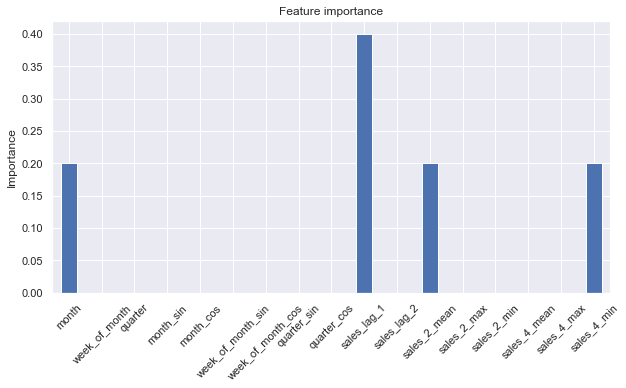

In [69]:
# Let's now plot the feature's importance
# according to the random forests.

# Create series with feature importance.
tmp = pd.Series(rf_model.feature_importances_)

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(10, 5), rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")

In [70]:
linear_model = Lasso(alpha=50, random_state=0)

linear_model.fit(X_train, y_train)

# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train, linear_model.predict(X_train), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test, linear_model.predict(X_test), squared=False,))

train rmse:  37698.750132003144
test rmse:  47263.45896829146


Text(0, 0.5, 'Importance')

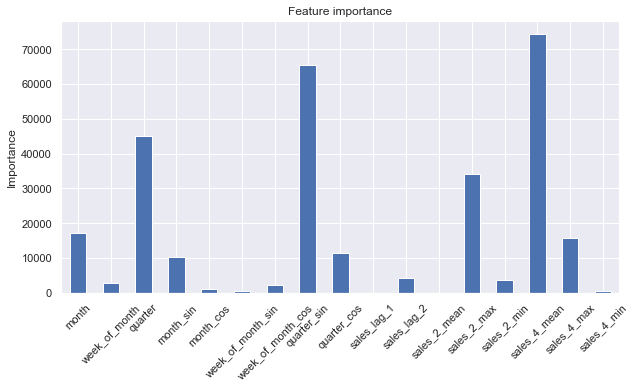

In [71]:
# Let's now plot the feature's importance
# according to the linear model.
from numpy import abs

# Create series with feature importance.
tmp = pd.Series(abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(10, 5), rot=45)
plt.title("Feature importance")
plt.ylabel("Importance")

In [72]:
lasso_coef=pd.DataFrame()
lasso_coef['columns']=df.columns
lasso_coef['coeffienct values']=pd.Series(linear_model.coef_)

In [73]:
lasso_coef

,columns,coeffienct values
0,sales,17170.183311
1,month,2815.383741
2,week_of_month,45129.165254
3,quarter,10314.597578
4,month_sin,-1085.816044
5,month_cos,387.957546
6,week_of_month_sin,-2089.872967
7,week_of_month_cos,65586.773690
8,quarter_sin,-11312.416859
9,quarter_cos,0.010529
